<a href="https://colab.research.google.com/github/joacalderonm/Feed_forward_Cifar-100/blob/main/Feed_Forward_cifar_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feed Forward cifar-100

###Introducción

En este proyecto desarrollaremos un clasificador de imágenes basado en Deep Learning utilizando el conjunto de datos CIFAR-100. La solución combina procesamiento de imágenes, redes neuronales profundas (MLP) y una interfaz web interactiva mediante Gradio para facilitar la visualización y uso del modelo.

###¿Qué es CIFAR-100?
CIFAR-100 es un conjunto de datos ampliamente utilizado en el campo del Deep Learning. Contiene 60,000 imágenes (50,000 entrenamiento - 10,000 prueba) a color de tamaño 32x32 píxeles, distribuidas en 100 clases diferentes, con 600 imágenes por clase (500 de entrenamiento - 100 de prueba). Estas clases incluyen objetos variados como animales, vehículos, árboles, frutas, instrumentos, etc.

###¿Qué haremos técnicamente?
1.-Carga y Preprocesamiento de Datos

2.-Construcción del Modelo

3.-Entrenamiento del Modelo

4.-Evaluación y Métricas

5.-Interfaz Interactiva con Gradio

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Bibliotecas escenciales
import numpy as np
from matplotlib import pyplot as plt
import datetime
import seaborn as sns
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


# Bibliotecas Tensorflow - Keras
from tensorflow import keras
import tensorflow as tf
%load_ext tensorboard
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import Callback, TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Manejo de datos
import pickle
import tarfile
import os


# Ruta al archivo .tar.gz
tar_path = "/content/drive/MyDrive/DataSets/Deep/cifar-100-python.tar.gz"

# Ruta donde descomprimir el archivo
extract_path = "/content/drive/MyDrive/DataSets/Deep/"

# Descomprimir el archivo
with tarfile.open(tar_path, "r:gz") as tar:
    tar.extractall(path=extract_path)

print(f"Archivo descomprimido en: {extract_path}")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Archivo descomprimido en: /content/drive/MyDrive/DataSets/Deep/


In [4]:
# set random seed
np.random.seed(30)
tf.random.set_seed(30)

## Rutas de archivos

In [5]:
# Función cargar archivos .pkl
def load_pickle(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(f, encoding="bytes")

# Rutas Drive
train_file_path = "/content/drive/MyDrive/DataSets/Deep/cifar-100-python/train"
meta_file_path = "/content/drive/MyDrive/DataSets/Deep/cifar-100-python/meta"
test_file_path = "/content/drive/MyDrive/DataSets/Deep/cifar-100-python/test"

# Cargar conjunto de datos
train_data = load_pickle(train_file_path)
test_data = load_pickle(test_file_path)
meta_data = load_pickle(meta_file_path)

## Preprocesamiento de los datos

In [6]:
def preprocessing_data(train_data, test_data, meta_data):
  """
  Selecciona y devuelve los datos de entrenamiento y prueba aplanados junto con
  los nombre de las clases

  Args:
    train_data: Datos de entrenamiento
    test_data: Datos de prueba
    meta_data: Datos de metadatos (Nombres de las clases)

  Returns:
    tuple: (X_train, y_train, X_test, y_test, class_names)
  """
  # Extraer imagenes y etiquetas de los datos de entrenamiento
  X_train = train_data[b"data"].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) # Aplanar y reordenar la imagen | Reshape (N, 3, 32, 32) / transpose (N, 32, 32 , 33)
  y_train = train_data[b"fine_labels"]

  # Extraer imagenes y etiquetas de los datos de prueba
  X_test = test_data[b"data"].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) # Aplanar y reordenar la imagen | Reshape (N, 3, 32, 32) / transpose (N, 32, 32 , 33)
  y_test = test_data[b"fine_labels"]

  # Cargar los nombres de las clases
  class_names = [name.decode('utf-8') for name in meta_data[b'fine_label_names']]
  return X_train, y_train, X_test, y_test, class_names

In [7]:
# Llamar a la función preprocessing_data
X_train, y_train, X_test, y_test, class_names = preprocessing_data(train_data, test_data, meta_data)

# Dimensiones
print("Conjunto de datos")
print("------"*3)
print(f"Datos de entrenamiento y características: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")
print(f"Cantidad de clases: {len(class_names)}")
print(f"Nombres de las clases: {class_names[:5]}")
print("------"*13)

Conjunto de datos
------------------
Datos de entrenamiento y características: (50000, 32, 32, 3)
Tamaño del conjunto de prueba: (10000, 32, 32, 3)
Cantidad de clases: 100
Nombres de las clases: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver']
------------------------------------------------------------------------------


### Visualizaciones y distribuciones de datos.

In [8]:
# Función para mostrar imágenes de ejemplo
def plot_sample_images(X, y, class_names, n_samples=10):
  """
  Muestra imágenes de ejemplo del conjunto de datos.

  Args:
    X_train: Imágenes de entrenamiento
    y_train: Etiquetas de entrenamiento
    class_names: Nombres de las clases
    n_samples: Número de imágenes a mostrar. Por defecto es 10.

  Returns:
    None: La función muestra las imágenes y no devuelve ningún valor.
  """

  plt.figure(figsize=(15, 3))
  for i in range(n_samples):
    plt.subplot(1, n_samples, i+1)
    # Seleccionar una imagen aleatoria del conjunto
    idx = np.random.randint(0, X.shape[0])
    plt.imshow(X[idx])
    plt.title(class_names[y[idx]])
    plt.axis("off")
  plt.tight_layout()
  plt.show()


# Verificar la distribución de clases
def plot_class_distribution(y, class_names, title, n_samples=10):
  """
  Muestra la distribución de clases en un gráfico de barras y sus estadísticas.

  Args:
    y_train: Etiquetas de clase
    class_names: Nombres de las clases
    title: Título del gráfico
    n_samples: Número de clases a mostrar. Por defecto es 10.

  Returns:
    None: La función muestra el gráfico y no devuelve ningún valor.

  """
  # Contar ejemplos por clase
  y = np.array(y)
  counts = np.bincount(y.flatten())

  # Limitar el número de clases a mostrar
  if n_samples > len(class_names):
    n_samples = len(class_names)

  # Crear gráfico de barras
  plt.figure(figsize=(12, 5))
  plt.bar(range(n_samples), counts[:n_samples], color="seagreen")
  plt.xticks(range(n_samples), class_names[:n_samples], rotation=45)
  plt.title(f"Distribución de clases: {title}")
  plt.xlabel("Clase")
  plt.ylabel("Número de ejemplos")
  plt.tight_layout()
  plt.show()

  # Imprimir estadísticas
  print(f"Total de ejemplos: {sum(counts)}")
  print(f"Minimo: {np.min(counts)}")

  print(f"Maximo: {np.max(counts)}")
  for i in range(n_samples):
    print(f"  - {class_names[i]}: {counts[i]} ({counts[i]/sum(counts)*100:.2f}%)")



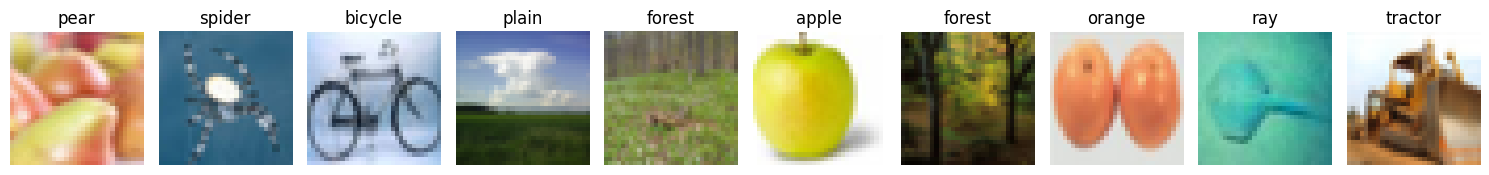

In [9]:
# Mostrar imágenes de ejemplo
plot_sample_images(X_train, y_train, class_names)

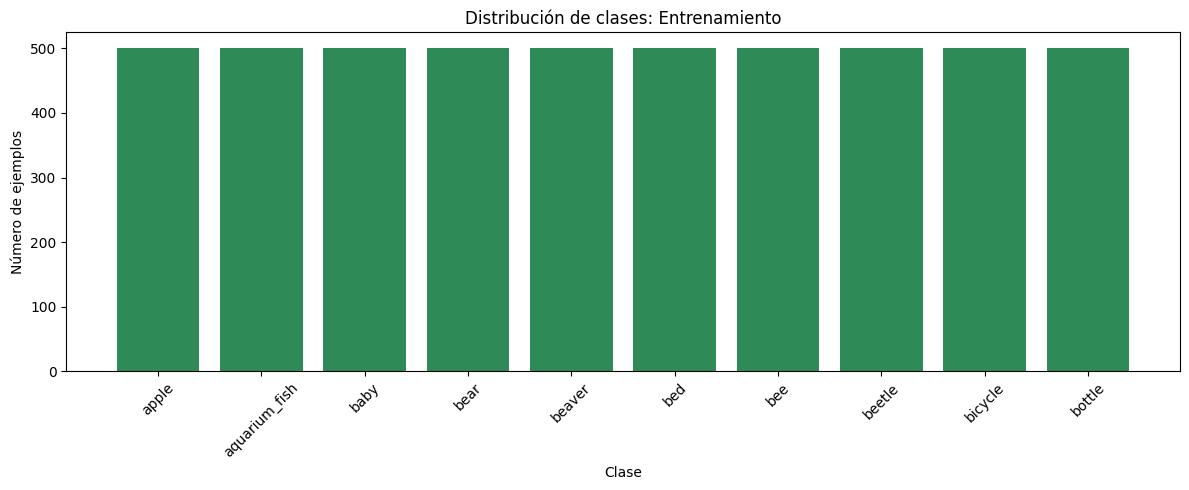

Total de ejemplos: 50000
Minimo: 500
Maximo: 500
  - apple: 500 (1.00%)
  - aquarium_fish: 500 (1.00%)
  - baby: 500 (1.00%)
  - bear: 500 (1.00%)
  - beaver: 500 (1.00%)
  - bed: 500 (1.00%)
  - bee: 500 (1.00%)
  - beetle: 500 (1.00%)
  - bicycle: 500 (1.00%)
  - bottle: 500 (1.00%)


In [10]:
# Mostrar distribución de clases para conjuntos de entrenamiento
plot_class_distribution(y_train, class_names, "Entrenamiento", n_samples=10)

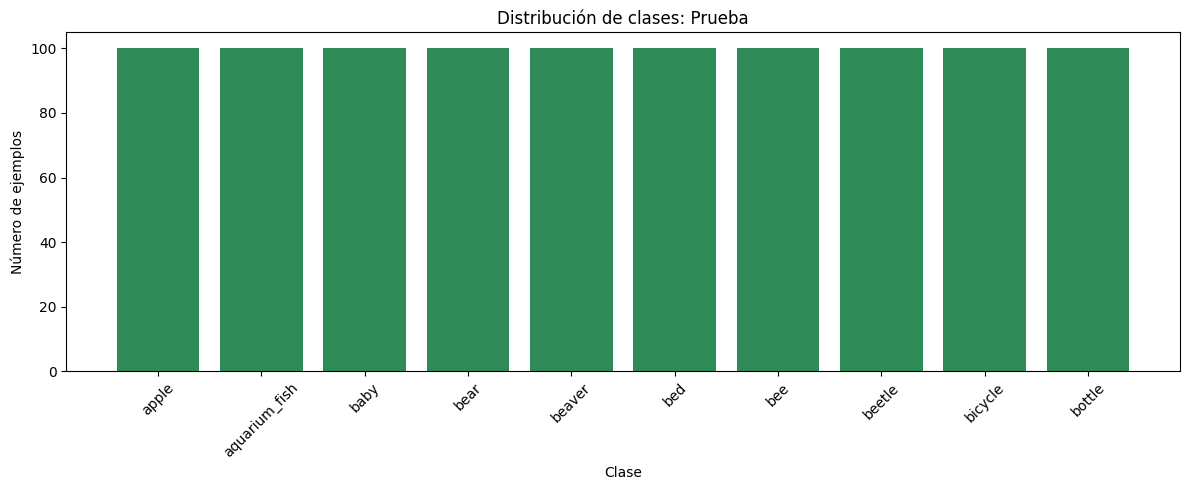

Total de ejemplos: 10000
Minimo: 100
Maximo: 100
  - apple: 100 (1.00%)
  - aquarium_fish: 100 (1.00%)
  - baby: 100 (1.00%)
  - bear: 100 (1.00%)
  - beaver: 100 (1.00%)
  - bed: 100 (1.00%)
  - bee: 100 (1.00%)
  - beetle: 100 (1.00%)
  - bicycle: 100 (1.00%)
  - bottle: 100 (1.00%)


In [11]:
# Mostrar distribución de clases para conjuntos de prueba
plot_class_distribution(y_test, class_names, "Prueba", n_samples=10)

### Normalización

In [12]:
def normalize_data(X_train, X_test, y_train, y_test):
  """
  Normaliza los datos de entrenamiento y prueba.

  Args:
    X_train: Imágenes de entrenamiento
    X_test: Imágenes de prueba
    y_train: Etiquetas de entrenamiento
    y_test: Etiquetas de prueba

  Returns:
    tuple: (X_train, X_test, y_train, y_test)

  """
  # Aplanar para usar en red feed-forward: (32, 32, 3) → (3072,)
  X_train = X_train.reshape(-1, 32 * 32 * 3)
  X_test = X_test.reshape(-1, 32 * 32 *  3)

  # Normalizar las imágenes (de [0, 255] a [0, 1])
  X_train = X_train.astype('float32') / 255
  X_test = X_test.astype('float32') / 255

  y_train = keras.utils.to_categorical(y_train, 100)
  y_test = keras.utils.to_categorical(y_test, 100)

  return X_train, X_test, y_train, y_test

In [13]:
X_train, X_test, y_train, y_test = normalize_data(X_train, X_test, y_train, y_test)

print("Datos de entrenamiento y características: ", X_train.shape)  # (50000, 3072)
print("Datos de entrenamiento y cantidad de clases: ", y_train.shape)  # (50000, 100)
print("-------------------------------------------------------------")
print("Datos de prueba y características: ", X_test.shape)  # (10000, 3072)
print("Datos de prueba y cantidad de clases: ", y_test.shape)

Datos de entrenamiento y características:  (50000, 3072)
Datos de entrenamiento y cantidad de clases:  (50000, 100)
-------------------------------------------------------------
Datos de prueba y características:  (10000, 3072)
Datos de prueba y cantidad de clases:  (10000, 100)


### Resumen

In [14]:
# cantidad de imagenes, neuronas de entrada y neuronas de salida (clases)

M = X_train.shape[0]
N = X_train.shape[1]
C = y_train.shape[1]

print("Datos de entrenamiento\n")
print("Cantidad de datos:", M) #(50000)
print("Neuronas de entrada:", N) #(3072)
print("Neuronas de salida :", C) #(100)

Datos de entrenamiento

Cantidad de datos: 50000
Neuronas de entrada: 3072
Neuronas de salida : 100


## MLP

### Modelo

In [ ]:
def create_mlp(input_shape, hidden_layers, hidden_units, activation="relu", dropout_rate = 0.0,
               regularization_rate = 0.0, output_units=100,
               output_activation="softmax"):

  """
  Crea un modelo MLP (Multilayer Perceptron) con capas densas.

  Args:
    input_shape: Cantidad de datos de entrada.
    hidden_layers: Número de capas ocultas.
    hidden_units: Lista de unidades en cada capa oculta.
    activation: Función de activación para las capas ocultas.
    dropout_rate: Tasa de dropout.
    regularization_rate: Tasa de regularización L2.
    output_units: Número de unidades de salida.
    output_activation: Función de activación para la capa de salida.

  Returns:
    Modelo MLP

  """

  model = keras.Sequential(name=f"MLP_dense_{hidden_layers}")

  # Capa de entrada
  model.add(layers.Input(shape = input_shape))

  # Capas ocultas
  for i in range (hidden_layers):
    model.add(layers.Dense(hidden_units[i], activation=activation,
                           kernel_regularizer=regularizers.l2(regularization_rate),
                           name=f"Dense_{i+1}"))

    # Agregar dropout si se requiere
    if dropout_rate > 0.0:
      model.add(layers.Dropout(dropout_rate, name=f"Dropout_{i+1}"))

  # Capa de salida
  model.add(layers.Dense(output_units, activation=output_activation, name=f"Output"))

  # Resumen del modelo
  model.summary()

  return model

# Parámetros de arquitectura

input_shape = (N,)  # (32x32x3 -> 3072)
hidden_layers = 2
hidden_units = [2048, 1024]  # Unidades por capa oculta
activation = "relu"
dropout_rate = 0.20
regularization_rate = 0.0005  # Regularización L2
output_units = C  # 100 clases
output_activation = "softmax"


# Crear el modelo
model = create_mlp(input_shape, hidden_layers, hidden_units, activation, dropout_rate,
                   regularization_rate, output_units, output_activation)


Model: "MLP_dense_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense_1 (Dense)                 │ (None, 2048)           │     6,293,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 100)            │       102,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,494,180 (32.40 MB)

 Trainable params: 8,494,180 (32.40 MB)

 Non-trainable params: 0 (0.00 B)

### Optimizadores

In [ ]:
learning_rate = 0.01
momentum = 0.9
nesterov = True

print("Parametros del optimizador")
print("---------------------------")
print(f"Learning rate: {learning_rate}: Controla el tamaño de los pasos durante la optimización.")
print(f"Momentum: {momentum}: Acelera la convergencia acumulando gradientes previos.")
print(f"Nesterov: {nesterov}: calcula los gradientes un paso adelante para mayor eficiencia.")

optimizer = SGD(
    learning_rate=learning_rate,
    momentum=momentum,
    nesterov=nesterov
)

# Compilador del modelo
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

Parametros del optimizador
---------------------------
Learning rate: 0.01: Controla el tamaño de los pasos durante la optimización.
Momentum: 0.9: Acelera la convergencia acumulando gradientes previos.
Nesterov: True: calcula los gradientes un paso adelante para mayor eficiencia.


### Callbacks

In [ ]:
# Carpeta base con timestamp
log_dir = "/content/drive/MyDrive/DataSets/Deep/cifar-100-python/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(log_dir, exist_ok=True)

# Subcarpetas para checkpoints y logs de tensorboard
checkpoint_dir = os.path.join(log_dir, "checkpoint")
tensorboard_log_dir = os.path.join(log_dir, "log")

os.makedirs(checkpoint_dir, exist_ok=True)

# Instanciar callbacks
callback = []

tensorboard_callback = TensorBoard(
    log_dir=tensorboard_log_dir, # Ruta para guardar perdida y presición.
    histogram_freq=1, # Cada epoca guarda los datos
    write_graph= True # Guarda la arquitectura del modelo
)

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "best_model_epoch.keras"),  # Ruta para guardar el mejor modelo
    monitor="val_accuracy",  # Monitorear la precisión de validación.
    save_best_only=True,  # Guardar solo el mejor modelo.
    save_weights_only=False,  # Guardar todo el modelo (no solo los pesos).
    verbose=1 # Mostrar texto.
)

early_stop_callback = EarlyStopping(
    monitor="val_loss", # Monitorear la pérdida de validación.
    patience=10, # Detener luego de 10 intentos sin mejora.
    restore_best_weights=True # Restaurar los pesos del mejor modelo.
)

lr_scheduler_callback  = ReduceLROnPlateau(
    monitor="val_loss", # Monitorear la pérdida de validación.
    factor=0.5, # Reducir la tasa de aprendijaze en un 50% cuando no exista mejora.
    patience=5, # Esperar 5 epocas sin mejora en la pérdida de validación
    verbose=1, # Mostrar texto
    min_lr=0.00001 # Tasa de aprendizaje mínima
)

callback.append(tensorboard_callback)
callback.append(checkpoint_callback)
callback.append(early_stop_callback)
callback.append(lr_scheduler_callback)

print("Callbacks")
print("------"*2)
print("1. Tensorboard")
print("   - Proposito: Seguir y visualizar métricas tales como la pérdida y la exactitud.")
print(f"   - Directorio log: '{log_dir}'")
print("   - Visualización a traves de %tensorboard -- logdir 'ruta' ")
print("------"*18)
print("2. Checkpoint")
print("   - Proposito: Guardar el mejor modelo durante el entrenamiento.")
print("   - Monitor: val_accuracy (Se guarda el mejor modelo con val_accuracy)")
print(f"   - Directorio checkpoint: '{checkpoint_dir}'")
print("------"*18)
print("3. Early stopping")
print("   - Proposito: Detener el entrenamiento si no hay mejoras.")
print("   - Monitor: val_loss (pérdida en el conjunto de validación)")
print("   - Patience: 10 epocas (10 epocas sin mejora para detenerse)")
print("------"*18)
print("4. Learning rate scheduler")
print("   - Proposito: Reducir la tasa de aprendizaje cuando val_loss deje de mejorar.")
print("   - Monitor: val_loss (pérdida en el conjunto de validación)")
print("   - Factor: Reduce en 50% la tasa de aprendizaje si no existe mejora.")
print("   - Patience: 5 epocas (5 epocas sin mejora para reducir la tasa de aprendizaje)")
print(f"   - min_lr: Tasa de aprendizaje mínima {lr_scheduler_callback.min_lr}")
print("------"*18)

# Configurar parámetros de entrenamiento
batch_size = 70
epochs = 100
validation_data = (X_test, y_test)
shuffle = True

print("\n"*2)
print("Parametros de entrenamiento")
print("---------------------------")
print(f"  - Batch size: ({batch_size}) Número de muestras procesadas antes de actualizar pesos.")
print(f"  - Epochs: ({epochs}) Cuantas veces el modelo verá el conjunto de datos.")
print(f"  - Validation data: Conjunto de datos de validación.")
print(f"  - Shuffle: ({shuffle}) Mezcla los datos antes de cada época.")

Callbacks
------------
1. Tensorboard
   - Proposito: Seguir y visualizar métricas tales como la pérdida y la exactitud.
   - Directorio log: '/content/drive/MyDrive/DataSets/Deep/cifar-100-python/20250424-174709'
   - Visualización a traves de %tensorboard -- logdir 'ruta' 
------------------------------------------------------------------------------------------------------------
2. Checkpoint
   - Proposito: Guardar el mejor modelo durante el entrenamiento.
   - Monitor: val_accuracy (Se guarda el mejor modelo con val_accuracy)
   - Directorio checkpoint: '/content/drive/MyDrive/DataSets/Deep/cifar-100-python/20250424-174709/checkpoint'
------------------------------------------------------------------------------------------------------------
3. Early stopping
   - Proposito: Detener el entrenamiento si no hay mejoras.
   - Monitor: val_loss (pérdida en el conjunto de validación)
   - Patience: 10 epocas (10 epocas sin mejora para detenerse)
----------------------------------------

### Entrenamiento

In [ ]:
start_time = time.time()

historia = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=shuffle,
    validation_data=validation_data,
    callbacks=callback
)

end_time = time.time()
training_time = end_time - start_time
print(f"Tiempo de entrenamiento: {training_time:.2f} segundos, {training_time/60:.2f} minutos")

# Mejor val_accuracy
print(f"Mejor val_accuracy: {np.max(historia.history['val_accuracy']):.4f}")

Epoch 1/100
715/715 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0531 - loss: 6.1535
Epoch 1: val_accuracy improved from -inf to 0.11850, saving model to /content/drive/MyDrive/DataSets/Deep/cifar-100-python/20250424-174709/checkpoint/best_model_epoch.keras
715/715 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.0531 - loss: 6.1532 - val_accuracy: 0.1185 - val_loss: 5.4790 - learning_rate: 0.0100
Epoch 2/100
709/715 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1223 - loss: 5.4038
Epoch 2: val_accuracy improved from 0.11850 to 0.14880, saving model to /content/drive/MyDrive/DataSets/Deep/cifar-100-python/20250424-174709/checkpoint/best_model_epoch.keras
715/715 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.1223 - loss: 5.4029 - val_accuracy: 0.1488 - val_loss: 5.1134 - learning_rate: 0.0100
Epoch 3/100
713/715 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1542 - loss: 5.0529
Epoch 3: val_accuracy improved from 0.14880 to 0.16620, saving model to /content/drive/MyDrive/DataSets/De

## Análisis

Matriz de Correlación.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


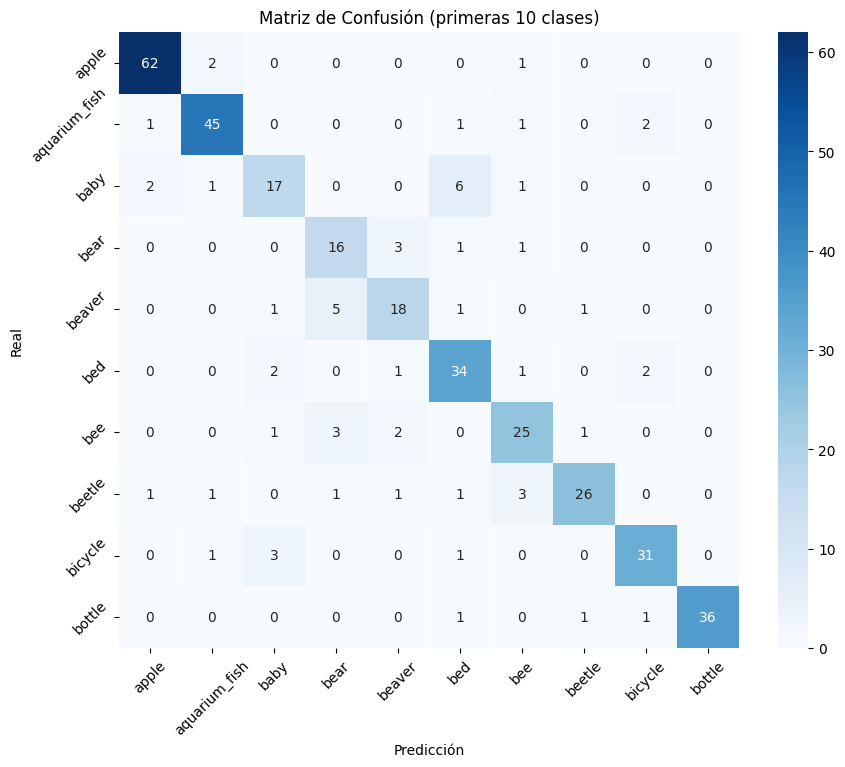

In [ ]:
# 1. Mejorar la visualización de la Matriz de Confusión

def plot_confusion_matrix(y_true, y_pred, class_names, max_classes=10):
    # Calcular la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Limitar a un número máximo de clases si se desea
    cm = cm[:max_classes, :max_classes]
    class_names = class_names[:max_classes]

    # Crear la visualización con seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, cbar=True)

    plt.title(f'Matriz de Confusión (primeras {max_classes} clases)')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()

# Predicciones sobre el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir las predicciones a etiquetas de clase

# Mostrar la matriz de confusión con solo las primeras 10 clases
plot_confusion_matrix(y_test.argmax(axis=1), y_pred_classes, class_names, max_classes=10)


Las predicciones para las primeras 10 clases. Los valores en la diagonal principal indican las predicciones correctas para cada clase (por ejemplo, 62 de las 100 imágenes de "apple" fueron correctamente clasificadas como "apple"), mientras que los valores fuera de la diagonal indican errores de clasificación.

### Gráficos de precición y validación.


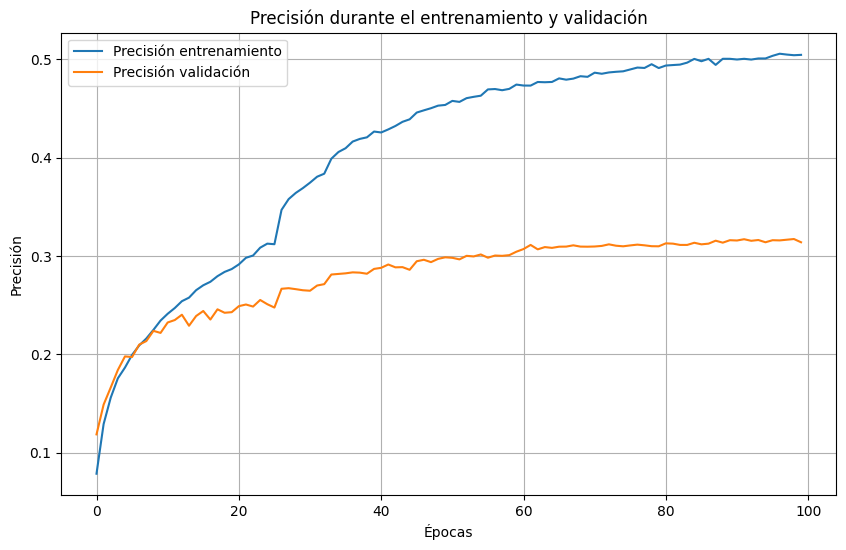

In [ ]:
# 2. Gráficos de Precisión y Precisión de Validación
def plot_precision_history(history):
    plt.figure(figsize=(10, 6))

    # Graficar precisión de entrenamiento y validación
    plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Precisión validación')

    plt.title('Precisión durante el entrenamiento y validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_precision_history(historia)


### Overfitting

In [ ]:
# 3. Verificación de Overfitting
def check_overfitting(history):
    # Si la precisión de validación comienza a disminuir mientras la precisión de entrenamiento sigue subiendo, es overfitting.
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Si la precisión de validación es menor que la de entrenamiento en las últimas épocas, hay overfitting
    if val_accuracy[-1] < train_accuracy[-1]:
        print("¡Posible Overfitting detectado!")
    else:
        print("No hay indicios claros de Overfitting.")

check_overfitting(historia)

¡Posible Overfitting detectado!


### Curva ROC.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


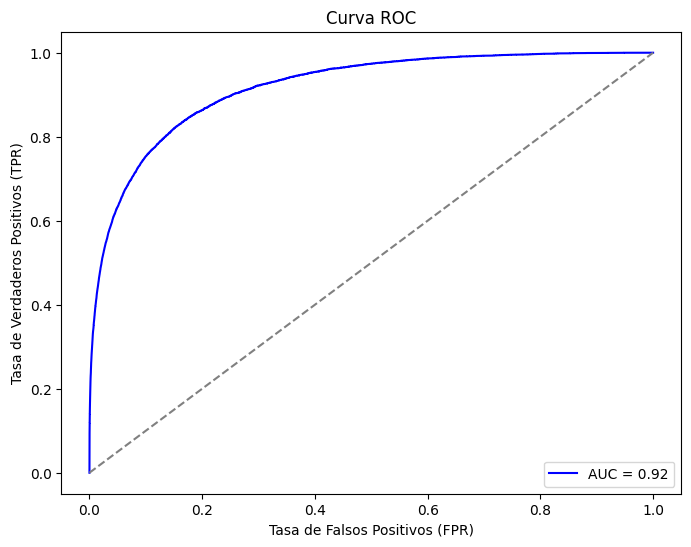

In [ ]:
# Binarizar las etiquetas para la clasificación multi-clase
y_test_bin = label_binarize(y_test.argmax(axis=1), classes=np.arange(len(class_names)))

# Calcular las predicciones probabilísticas
y_pred_prob = model.predict(X_test)

# Calcular la curva ROC y AUC para cada clase
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
roc_auc = auc(fpr, tpr)

# Mostrar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.show()


AUC de 0.92 sugiere que el modelo tiene una alta capacidad y es muy bueno en términos de su habilidad para predecir correctamente.


### Reporte de clasificación

In [ ]:
# Generar el reporte de clasificación
report = classification_report(y_test.argmax(axis=1), y_pred_classes, target_names=class_names, output_dict=True)

# Convertir el reporte en un DataFrame
report_df = pd.DataFrame(report).T

# Mostrar el reporte para ver las métricas por clase
print(report_df)


               precision  recall  f1-score    support
apple           0.584906   0.620  0.601942    100.000
aquarium_fish   0.340909   0.450  0.387931    100.000
baby            0.207317   0.170  0.186813    100.000
bear            0.205128   0.160  0.179775    100.000
beaver          0.176471   0.180  0.178218    100.000
...                  ...     ...       ...        ...
woman           0.116667   0.070  0.087500    100.000
worm            0.245033   0.370  0.294821    100.000
accuracy        0.316000   0.316  0.316000      0.316
macro avg       0.313211   0.316  0.308126  10000.000
weighted avg    0.313211   0.316  0.308126  10000.000

[103 rows x 4 columns]


In [ ]:
# Seleccionar las mejores 5 clases (las que tienen la mayor precisión)
best_classes = report_df['precision'].sort_values(ascending=False).head(5)

# Seleccionar las peores 5 clases (las que tienen la menor precisión)
worst_classes = report_df['precision'].sort_values(ascending=True).head(5)

print(f"Mejores clases:\n{best_classes}\n")
print(f"Peores clases:\n{worst_classes}\n")


Mejores clases:
lawn_mower    0.616279
chair         0.586538
apple         0.584906
sunflower     0.583333
plain         0.561538
Name: precision, dtype: float64

Peores clases:
squirrel    0.093960
otter       0.094340
snail       0.101266
tiger       0.109890
woman       0.116667
Name: precision, dtype: float64



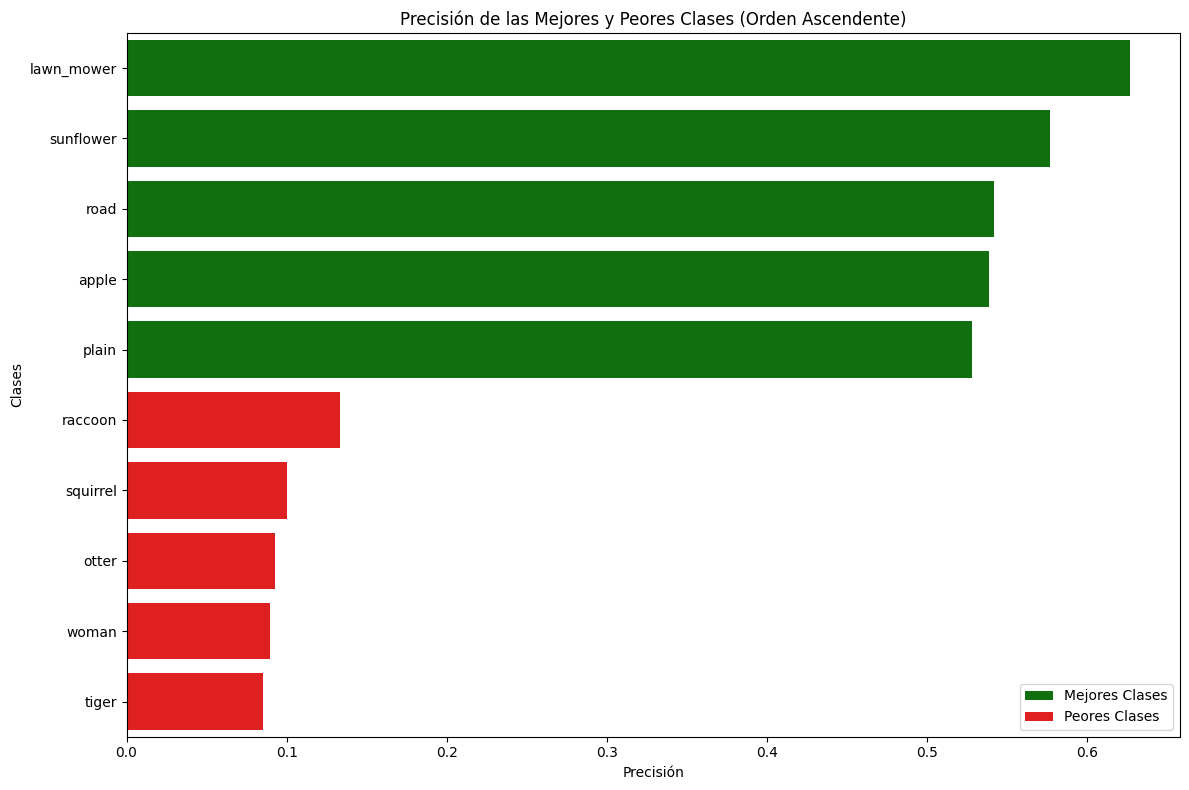

In [ ]:
# Precisión de las mejores clases
best_classes_precision = {
    'lawn_mower': 0.626506,
    'sunflower': 0.576923,
    'road': 0.541667,
    'apple': 0.538462,
    'plain': 0.527778
}

# Precisión de las peores clases
worst_classes_precision = {
    'tiger': 0.085366,
    'woman': 0.089744,
    'otter': 0.092593,
    'squirrel': 0.100000,
    'raccoon': 0.133333
}

# Convertir a DataFrame para facilitar la visualización
best_classes_df = pd.DataFrame(list(best_classes_precision.items()), columns=["Clase", "Precisión"])
worst_classes_df = pd.DataFrame(list(worst_classes_precision.items()), columns=["Clase", "Precisión"])

# Ordenar las clases por precisión de forma ascendente
best_classes_df = best_classes_df.sort_values(by='Precisión', ascending=False)
worst_classes_df = worst_classes_df.sort_values(by='Precisión', ascending=False)

# Configurar el gráfico
plt.figure(figsize=(12, 8))

# Graficar las mejores clases en orden ascendente
sns.barplot(x='Precisión', y='Clase', data=best_classes_df, color='green', label='Mejores Clases')

# Graficar las peores clases en orden ascendente
sns.barplot(x='Precisión', y='Clase', data=worst_classes_df, color='red', label='Peores Clases')

# Añadir títulos y etiquetas
plt.title('Precisión de las Mejores y Peores Clases (Orden Ascendente)')
plt.xlabel('Precisión')
plt.ylabel('Clases')

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()


## Implementación de gradio

In [15]:
!pip install gradio
import gradio as gr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.1 MB/s eta 0:00:00


In [22]:
# Cargar el modelo previamente entrenado (reemplaza con la ruta correcta de tu modelo)
model = tf.keras.models.load_model('/content/drive/MyDrive/DataSets/Deep/cifar-100-python/20250424-174709/checkpoint/best_model_epoch.keras')  # Asegúrate de cargar tu modelo entrenado

# 1. Función para cargar las clases de CIFAR-100
def load_class_names(meta_data):
    """
    Carga los nombres de las clases finas y gruesas desde los metadatos de CIFAR-100.

    Args:
    - meta_data: Diccionario con los metadatos de CIFAR-100

    Returns:
    - fine_names: Lista con los nombres de las clases finas
    - coarse_names: Lista con los nombres de las clases gruesas
    """
    fine_names = [name.decode('utf-8') for name in meta_data[b'fine_label_names']]
    coarse_names = [name.decode('utf-8') for name in meta_data[b'coarse_label_names']]
    return fine_names, coarse_names

# Verificar cuántas clases tiene el modelo
fine_names, coarse_names = load_class_names(meta_data)

# Función para predecir la clase de una imagen cargada
def predict_image(img):
    try:
        # Redimensionar la imagen a 32x32 píxeles
        img = img.resize((32, 32))  # Redimensionar la imagen para que coincida con el tamaño de entrada de tu modelo

        # Convertir la imagen en un array de numpy
        img_array = np.array(img)

        # Verificar que la imagen tenga 3 canales (RGB)
        if img_array.shape[-1] != 3:
            raise ValueError("La imagen debe tener 3 canales (RGB).")

        # Normalizar la imagen (escala de 0 a 1)
        img_array = img_array / 255.0  # Normalizar la imagen

        # Aplanar la imagen para que tenga la forma (1, 3072)
        img_array = img_array.flatten()  # Aplanar la imagen a un vector de tamaño 3072
        img_array = np.expand_dims(img_array, axis=0)  # Añadir la dimensión del batch

        # Hacer la predicción
        predictions = model.predict(img_array)

        # Obtener la clase con la probabilidad más alta
        predicted_class = np.argmax(predictions, axis=1)[0]

        # Verificar que el índice esté dentro del rango de las clases
        if predicted_class < 0 or predicted_class >= len(fine_names):
            raise IndexError(f"El índice predicho {predicted_class} está fuera del rango de clases.")

        return fine_names[predicted_class], coarse_names[predicted_class]  # Devolver el nombre de la clase correspondiente

    except Exception as e:
        return f"Error: {e}"

# Interfaz de Gradio
def create_interface():
    # Crear una interfaz de Gradio con la nueva API
    interface = gr.Interface(fn=predict_image,
                             inputs=gr.Image(type="pil", image_mode='RGB'),
                             outputs=[
                                 gr.Textbox(label="Clase Fina"),
                                 gr.Textbox(label="Clase Gruesa")
                             ],
                             live=True,  # Si deseas ver la predicción en tiempo real
                             title="Clasificador de Imágenes",
                             description="Carga una imagen para predecir su clase fina y gruesa."
                            )

    interface.launch()  # Lanzar la interfaz

# Llamar a la función para lanzar la interfaz
create_interface()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ca4578d87976eef9ec.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Ventajas de usar Gradio:

- Fácil de compartir: El enlace público permite compartir con cualquier persona.
- Feedback visual: Muestra las probabilidades de las principales predicciones.
- Interfaz amigable: Permite a las personas interactuar con el modelo sin la necesidad de escribir código.

### Mejoras que se pueden implementar:

1. Añadir más ejemplos predefinidos.
2. Mostrar la imagen preprocesada (32x32) junto con la original.
3. Añadir visualización de mapas de activación.
4. Implementar comparación entre MLP y CNN usando pestañas.
5. Crear un histórico de predicciones para analizar patrones.

## ==== Conclusiones ====
1. Rendimiento General:
   ❌ El modelo MLP no logró un buen rendimiento para CIFAR-100.

2. Limitaciones:
   - Las MLPs procesan imágenes aplanadas, perdiendo la información espacial.
   - Para imágenes, las redes convolucionales (CNN) suelen tener mejor rendimiento.
   - El modelo puede tener dificultades con objetos rotados o en diferentes posiciones.
   -El modelo tiene overfitting.

3. Mejoras Potenciales:
   - Probar arquitecturas más complejas (más capas, más unidades).
   - Implementar técnicas de aumentación de datos (rotaciones, volteos, zoom).
   - Ajustar los hiperparámetros mediante búsqueda de cuadrícula o aleatoria.
   - Migrar a una arquitectura CNN para mejorar significativamente el rendimiento.

4. Comparación con otro tipo de arquitecturas:
  - Convolucionales

   